# Impact of number of particles
We investigate the impact of the number of particles in this notebook.

In [1]:
using PSO, CUDA, Random
using Plots, StatsPlots
using LaTeXStrings
using BSON: @save, @load

const data_dir = "../data/"
include("utils.jl")

# set random seed: for reproduction
Random.seed!(CURAND.default_rng(), 123)

## Read data and set up search range

In [2]:
# select data type to be used on GPU: Float64 or Float32
# Float32 tends to be a little faster, but with lower precision
const TF = Float64  

Float64

In [3]:
const T = TF(33 + 273.15)  # temperature in Kalvin of the RTC France case

const data = read_data(joinpath(data_dir, "RTFrance.csv"), TF);

In [4]:
const x_min = TF[0, 0, 0, 1, 1, 0,   0]
const x_max = TF[1, 1, 1, 2, 2, 0.5, 100];

## Fixed PSO parameters

In [5]:
# the following PSO parameters are fixed
const w = TF(0.5)
const c1 = TF(2.5)
const c2 = TF(1.6)
const niter = 400  # allowed maximum number of iterations
const min_delta = TF(1e-10) 
const nps = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
# const nps = [32, 64]

8-element Vector{Int64}:
   64
  128
  256
  512
 1024
 2048
 4096
 8192

In [20]:
function measure(np::Integer; n_trials=100, patience=typemax(Int))
    @assert np % 32 == 0
    threads = 256
    if np < 256
        threads = np
    end
    @show np
    f = () -> pso(data, T, :DDM, x_min, x_max; niter, np, w, c1, c2, log=false, threads, min_delta, patience)
    N = size(data, 2)
    # RMSE and termination iterations
    rmse = zeros(n_trials)
    iter = zeros(Int, n_trials)
    for i = 1:n_trials
        # res = pso(data, T, :DDM, x_min, x_max; niter, np, w, c1, c2, log=false, threads, min_delta, patience)
        res = f()
        rmse[i] = sqrt(res.sse / N)
        iter[i] = res.stopped_iter
    end
    # bt = @benchmark pso(data, T, :DDM, x_min, x_max; niter, np=$np, w, c1, c2, log=false, threads=$threads, min_delta, patience) evals=1 samples=n_trials
    bt = @benchmark $f() evals=1 samples=n_trials
    return (rmse=rmse, iter=iter, time=mean(bt).time/1e9) # ns -> s 
end

measure (generic function with 2 methods)

In [21]:
function measure(nps::Vector, save_file::String; n_trials=100, patience=typemax(Int))
    records = Dict{Int, NamedTuple}()
    for np in nps
        records[np] = measure(np; n_trials, patience)    
    end
    @save save_file records
end

measure (generic function with 2 methods)

## Run a fixed number of iterations without early stopping
We simply set `patience` to a huge value to disable early termination.

**NOTE**: it will take around 10 minutes, you may skip this step and reuse the data file we have stored.

In [28]:
measure(nps, "records-$(niter).bson")

np = 64
np = 128
np = 256
np = 512
np = 1024
np = 2048
np = 4096
np = 8192


## Enable early stopping

**NOTE**: it will take around 10 minutes, you may skip this step and reuse the data file we have stored.

In [9]:
measure(nps, "records-ES.bson"; patience=30)

np = 64
np = 128
np = 256
np = 512
np = 1024
np = 2048
np = 4096
np = 8192


## Visualization

### A fixed number of iterations: check the RMSE and runtime

In [48]:
@load "records-400.bson" records

In [49]:
using DataFrames
df = DataFrame()
df[!, :rmse] = vcat((records[np][:rmse] for np in nps)...) .* 1e4
# df[!, :np] = repeat(nps; inner=100)
# a workaround to adjust the x order of boxplot
df[!, :np] = repeat(["$(i)-$(nps[i])" for i = 1:length(nps)]; inner=100);

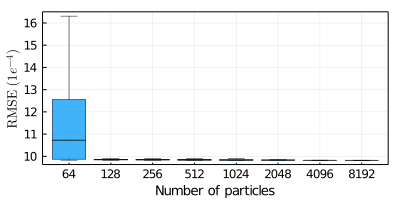

In [50]:
x_pos = range(0.5; length=length(nps))
plot(size=(400, 200), labelfontsize=9, framestyle=:box)
@df df boxplot!(:np, :rmse, fillalpha=0.75, linewidth=0.5, markersize=1, outliers=false,
    legend=:topright, ylabel=L"\textrm{RMSE } (1e^{-4})",xticks=(x_pos, nps),
    xlabel="Number of particles", label=:none)
# lens!([1, 4], [9.5, 10.5], inset=(1, bbox(0.4, 0.15, 0.5, 0.3)), framestyle=:box, 
#     xticks=(1:4, 9:12))


In [51]:
savefig("./img/RMSE-NP.pdf")

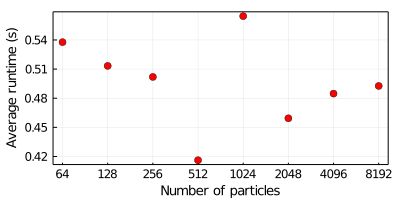

In [38]:
plot(size=(400, 200), labelfontsize=9, framestyle=:box)
x_pos = 1:length(nps)
scatter!(x_pos, [records[np][:time] for np in nps]; label=:none, 
    xticks=(x_pos, nps), color=:red, xlabel="Number of particles", ylabel="Average runtime (s)")

In [39]:
savefig("./img/time-NP.pdf")

### With early termination

In [44]:
@load "records-ES.bson" records

In [45]:
df = DataFrame()
df[!, :iter] = vcat((records[np][:iter] for np in nps)...)
# df[!, :np] = repeat(nps; inner=100)
# a workaround to adjust the x order of boxplot
df[!, :np] = repeat(["$(i)-$(nps[i])" for i = 1:length(nps)]; inner=100)
;

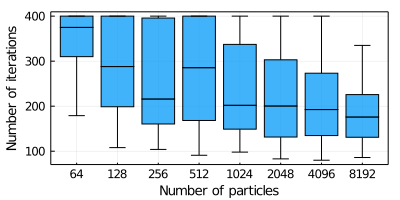

In [46]:
x_pos = range(0.5; length=length(nps))
plot(size=(400, 200), labelfontsize=9, framestyle=:box)
@df df boxplot!(:np, :iter, fillalpha=0.75, linewidth=1, markersize=1, outliers=false,
    label=:none, legend=:topright, ylabel="Number of iterations", xlabel="Number of particles", 
    xticks=(x_pos, nps))

In [47]:
savefig("./img/iter-NP.pdf")